In [1]:
using Distributed
addprocs(44);

In [2]:
using PulseInputDDM, MAT, Flatten
import Statistics: mean, median

In [3]:
x_joint = Vector(undef, 3);

In [4]:
ratnames = ["B068","T034","T036","T063","T030", "T035","T011","B053", "T080","T103","E021"];
dt, n, cross = 1e-2, 53, false
delay, nconds = 0, 2
data_path = joinpath(abspath(joinpath(pwd(), "..")), "data/by_session")
joint_model_path = joinpath(abspath(joinpath(pwd(), "..")), "models/joint");

# FOF

In [5]:
file = joinpath(joint_model_path, "Fig2-FOF.mat")
xf = read(matopen(file), "ML_params");
x_joint[1] = xf;

## Load the neural data

In [6]:
ratnum = 1:5
rat = ratnames[ratnum];
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data, μ_rnt_FOF, μ_t = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, 
    filtSD=5, do_RBF=true);
μ_t_FOF = vcat(μ_t...);

In [7]:
ncells = map(x-> x[1].ncells, data);

## Organize the spiking data to produce PSTHs

In [8]:
output = process_spike_data.(μ_rnt_FOF, data; nconds=nconds);
μ_ct, σ_ct = getindex.(output, 1), getindex.(output, 2);
μ_ct_FOF, σ_ct_FOF = vcat(μ_ct...), vcat(σ_ct...);    

## Organize data and parameters to simulate spikes from the model

In [9]:
f = repeat(["Softplus"], sum(ncells))
borg = vcat(0,cumsum(ncells))
f = [f[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];

model_FOF = neuralDDM(θ=θneural(x_joint[1][setdiff(1:length(x_joint[1]), 8:9)], f), 
    data=data, n=n, cross=cross);

In [10]:
import PulseInputDDM: simulate_expected_spikes

In [11]:
μ_λ_FOF, μ_c_λ, = simulate_expected_firing_rate(model_FOF; num_samples=20, nconds=nconds);
μ_c_λ_FOF = vcat(μ_c_λ...);

## Compute the error between the empirical and simulated PSTH

In [12]:
flatall = map(x-> vcat(map(x-> getindex(x, 1:70), x)...), μ_ct_FOF);
flatsim = map(x-> vcat(map(x-> getindex(x, 1:70), x)...), μ_c_λ_FOF);
meanall = mean.(flatall);
dataminusmean_all = map((x,y) -> x .- y, flatall, meanall);
theerror2 = map((x,y) -> x .- y, flatall, flatsim);
simR2_FOF = 1 .- sum.(map(x-> x.^2, theerror2)) ./ sum.(map(x-> x.^2, dataminusmean_all));

## Reorganize the data into structure types for choices

In [13]:
choice_inputs = map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=dt, centered=false), getfield.(vcat(data...), :input_data));
choice_data = PulseInputDDM.choicedata.(choice_inputs, getfield.(vcat(data...), :choice));
choice_FOF = getfield.(choice_data, :choice);

In [14]:
output = map(x-> binLR(x.click_data.binned_clicks, x.click_data.clicks, x.click_data.dt), choice_data);
L,R = getindex.(output,1), getindex.(output,2);
ΔLR_FOF = last.(cumsum.(-L .+ R));

In [15]:
syn_choice_joint_FOF = rand.(Ref(Flatten.reconstruct(θchoice(), x_joint[1][1:9])), choice_inputs, 
    1:length(choice_inputs));

## Compute the logistic functions for the data and the simulated data

In [16]:
using Optim, LineSearches, ForwardDiff, Distributions
w0 = [0.1, 1., 0.];

In [17]:
mylogit(w) = (w[1]/2 .+ (1 .- w[1]) ./ (1. .+ exp.(-w[2]*ΔLR_FOF .+ w[3])));
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), choice_FOF))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
m = BFGS(alphaguess = InitialStatic(alpha=1.0,scaled=true), linesearch = BackTracking());
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_data_FOF = Optim.minimizer(output);

In [18]:
x_FOF = sort(ΔLR_FOF);
idx_FOF = sortperm(ΔLR_FOF)
y_data_FOF = mylogit(what_data_FOF)[idx_FOF];

In [19]:
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), syn_choice_joint_FOF))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_choice_joint_FOF = Optim.minimizer(output);
y_choice_joint_FOF = mylogit(what_choice_joint_FOF)[idx_FOF];

## Compute box plots around each data point

In [20]:
using HypothesisTests, CategoricalArrays
labels = string.(1:10);

In [21]:
mylogit(w,x) = (w[1]/2 .+ (1 .- w[1]) ./ (1. .+ exp.(-w[2]*x .+ w[3])));

In [22]:
LR_FOF = map(x-> mean(ΔLR_FOF[cut(ΔLR_FOF, length(labels), labels=labels) .== x]), labels);
ys_FOF_data = map(x-> choice_FOF[cut(ΔLR_FOF, length(labels), labels=labels) .== x], labels);
CIs_data_FOF = collect.(confint.(BinomialTest.(ys_FOF_data, mylogit.(Ref(what_data_FOF), LR_FOF))));

## PPC

In [23]:
file = joinpath(joint_model_path, "Fig2-PPC.mat")
xf = read(matopen(file), "ML_params");
x_joint[2] = xf;

In [24]:
ratnum = 6:8
rat = ratnames[ratnum]
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data, μ_rnt_PPC, μ_t_PPC = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, 
    filtSD=5, do_RBF=true);

In [25]:
μ_t_PPC = vcat(μ_t_PPC...);
ncells = map(x-> x[1].ncells, data);

In [26]:
output = process_spike_data.(μ_rnt_PPC, data; nconds=nconds);
μ_ct, σ_ct = getindex.(output, 1), getindex.(output, 2);
μ_ct_PPC, σ_ct_PPC = vcat(μ_ct...), vcat(σ_ct...);

In [27]:
f = repeat(["Softplus"], sum(ncells))
borg = vcat(0,cumsum(ncells))
f = [f[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];
model_PPC = neuralDDM(θ=θneural(x_joint[2][setdiff(1:length(x_joint[2]), 8:9)], f), 
    data=data, n=n, cross=cross);

In [28]:
μ_λ_PPC, μ_c_λ, = simulate_expected_firing_rate(model_PPC; num_samples=20, nconds=nconds); 
μ_c_λ_PPC = vcat(μ_c_λ...);

In [29]:
flatall = map(x-> vcat(map(x-> getindex(x, 1:70), x)...), μ_ct_PPC);
flatsim = map(x-> vcat(map(x-> getindex(x, 1:70), x)...), μ_c_λ_PPC);
meanall = mean.(flatall);
dataminusmean_all = map((x,y) -> x .- y, flatall, meanall);
theerror2 = map((x,y) -> x .- y, flatall, flatsim);
simR2_PPC = 1 .- sum.(map(x-> x.^2, theerror2)) ./ sum.(map(x-> x.^2, dataminusmean_all));

In [30]:
choice_inputs = map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=dt, centered=false), getfield.(vcat(data...), :input_data));
choice_data = PulseInputDDM.choicedata.(choice_inputs, getfield.(vcat(data...), :choice));
choice_PPC = getfield.(choice_data, :choice);

In [31]:
syn_choice_joint_PPC = rand.(Ref(Flatten.reconstruct(θchoice(), x_joint[2][1:9])), choice_inputs, 
    1:length(choice_inputs));

In [32]:
output = map(x-> binLR(x.click_data.binned_clicks, x.click_data.clicks, x.click_data.dt), choice_data);
L,R = getindex.(output,1), getindex.(output,2);
ΔLR_PPC = last.(cumsum.(-L .+ R));

In [33]:
mylogit(w) = (w[1]/2 .+ (1 .- w[1]) ./ (1. .+ exp.(-w[2]*ΔLR_PPC .+ w[3])));

In [34]:
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), choice_PPC))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
m = BFGS(alphaguess = InitialStatic(alpha=1.0,scaled=true), linesearch = BackTracking());
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_data_PPC = Optim.minimizer(output);

In [35]:
x_PPC = sort(ΔLR_PPC);
idx_PPC = sortperm(ΔLR_PPC)
y_data_PPC = mylogit(what_data_PPC)[idx_PPC];

In [36]:
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), syn_choice_joint_PPC))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_choice_joint_PPC = Optim.minimizer(output);
y_choice_joint_PPC = mylogit(what_choice_joint_PPC)[idx_PPC];

In [37]:
LR_PPC = map(x-> mean(ΔLR_PPC[cut(ΔLR_PPC, length(labels), labels=labels) .== x]), labels);
ys_PPC_data = map(x-> choice_PPC[cut(ΔLR_PPC, length(labels), labels=labels) .== x], labels);
CIs_data_PPC = collect.(confint.(BinomialTest.(ys_PPC_data, mylogit.(Ref(what_data_PPC), LR_PPC))));

## ADS

In [38]:
file = joinpath(joint_model_path, "Fig2-ADS.mat")
xf = read(matopen(file), "ML_params");
x_joint[3] = xf;

In [39]:
ratnum = 9:11
rat = ratnames[ratnum]
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data, μ_rnt_STR, μ_t = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, 
    filtSD=5, do_RBF=true);
μ_t_STR = vcat(μ_t...);
ncells = map(x-> x[1].ncells, data);

In [40]:
output = process_spike_data.(μ_rnt_STR, data; nconds=nconds);
μ_ct, σ_ct = getindex.(output, 1), getindex.(output, 2);
μ_ct_STR, σ_ct_STR = vcat(μ_ct...), vcat(σ_ct...);

In [41]:
f = repeat(["Softplus"], sum(ncells))
borg = vcat(0,cumsum(ncells))
f = [f[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];

model_STR = neuralDDM(θ=θneural(x_joint[3][setdiff(1:length(x_joint[3]), 8:9)], f), 
    data=data, n=n, cross=cross);

In [42]:
μ_λ_STR, μ_c_λ, = simulate_expected_firing_rate(model_STR; num_samples=20, nconds=nconds); 
μ_c_λ_STR = vcat(μ_c_λ...);

In [43]:
flatall = map(x-> vcat(map(x-> getindex(x, 1:70), x)...), μ_ct_STR);
flatsim = map(x-> vcat(map(x-> getindex(x, 1:70), x)...), μ_c_λ_STR);
meanall = mean.(flatall);
dataminusmean_all = map((x,y) -> x .- y, flatall, meanall);
theerror2 = map((x,y) -> x .- y, flatall, flatsim);
simR2_STR = 1 .- sum.(map(x-> x.^2, theerror2)) ./ sum.(map(x-> x.^2, dataminusmean_all));

In [44]:
choice_inputs = map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=dt, centered=false), getfield.(vcat(data...), :input_data));
choice_data = PulseInputDDM.choicedata.(choice_inputs, getfield.(vcat(data...), :choice));
choice_STR = getfield.(choice_data, :choice);

In [45]:
syn_choice_joint_STR = rand.(Ref(Flatten.reconstruct(θchoice(), x_joint[3][1:9])), choice_inputs, 
    1:length(choice_inputs));

In [46]:
output = map(x-> binLR(x.click_data.binned_clicks, x.click_data.clicks, x.click_data.dt), choice_data);
L,R = getindex.(output,1), getindex.(output,2);
ΔLR_STR = last.(cumsum.(-L .+ R));

In [47]:
mylogit(w) = (w[1]/2 .+ (1 .- w[1]) ./ (1. .+ exp.(-w[2]*ΔLR_STR .+ w[3])));
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), choice_STR))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_data_STR = Optim.minimizer(output);

In [48]:
x_STR = sort(ΔLR_STR);
idx_STR = sortperm(ΔLR_STR)
y_data_STR = mylogit(what_data_STR)[idx_STR];

In [49]:
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), syn_choice_joint_STR))
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_choice_joint_STR = Optim.minimizer(output);
y_choice_joint_STR = mylogit(what_choice_joint_STR)[idx_STR];

In [50]:
LR_STR = map(x-> mean(ΔLR_STR[cut(ΔLR_STR, length(labels), labels=labels) .== x]), labels);
ys_STR_data = map(x-> choice_STR[cut(ΔLR_STR, length(labels), labels=labels) .== x], labels);
CIs_data_STR = collect.(confint.(BinomialTest.(ys_STR_data, mylogit.(Ref(what_data_STR), LR_STR))));

In [51]:
median(simR2_FOF)

0.9091266600293457

In [52]:
median(simR2_PPC)

0.6805215347583465

In [53]:
median(simR2_STR)

0.8715555886867048

## Plot

In [54]:
using Colors, PyPlot

In [55]:
my_colors_STR= map(x-> "#"*x, hex.(range(colorant"#A01892", stop=colorant"#E9E62F", length=nconds)));
my_colors_PPC= map(x-> "#"*x, hex.(range(colorant"#1822A0", stop=colorant"#E99C2F", length=nconds)));
my_colors_FOF= map(x-> "#"*x, hex.(range(colorant"red", stop=colorant"green", length=nconds)));

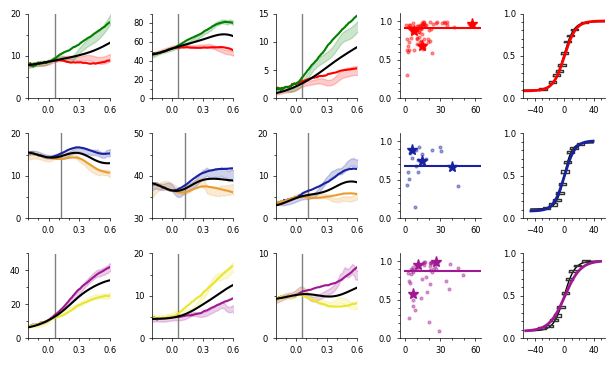

In [57]:
toplot = [8,7,21]
toplotPPC = toplot

fs = 6

rc("xtick", labelsize=fs)
rc("ytick", labelsize=fs)
rc("font", family="sans-serif")

fig, ax = subplots(3, 5, figsize=(1.25 * 5, 1.25 * 3))

idxs = [2,5,8]

for j in 1:length(toplot) 
    
    if j == 1
        ax[idxs[j]].plot(0.12*ones(100), range(0, stop=20, length=100), color=[0.5,0.5,0.5], LineStyle="-",
            LineWidth=1)
    elseif j == 2
        ax[idxs[j]].plot(0.12*ones(100), range(0, stop=60, length=100), color=[0.5,0.5,0.5], LineStyle="-",
            LineWidth=1)
    elseif j == 3
        ax[idxs[j]].plot(0.12*ones(100), range(0, stop=20, length=100), color=[0.5,0.5,0.5], LineStyle="-", 
            LineWidth=1)
    end

    for k = 1:nconds   

        ax[idxs[j]].fill_between((1:length(μ_ct_PPC[toplot[j]][k]))*dt .-0.2,
            μ_ct_PPC[toplot[j]][k] + σ_ct_PPC[toplot[j]][k],
            μ_ct_PPC[toplot[j]][k] - σ_ct_PPC[toplot[j]][k],
            alpha=0.2, color=my_colors_PPC[k]) 
        
        ax[idxs[j]].plot((1:length(μ_c_λ_PPC[toplot[j]][k]))*dt.-0.2,
            μ_c_λ_PPC[toplot[j]][k], color=my_colors_PPC[k])  

    end   

    ax[idxs[j]].plot((1:length(μ_t_PPC[toplot[j]]))*dt .-0.2,
       μ_t_PPC[toplot[j]], color="black") 
    
    ax[idxs[j]].spines["right"].set_visible(false)
    ax[idxs[j]].spines["top"].set_visible(false)
    ax[idxs[j]].spines["bottom"].set_linewidth(0.5)
    ax[idxs[j]].spines["left"].set_linewidth(0.5)
    ax[idxs[j]].tick_params(width=0.5, length=2)
    ax[idxs[j]].set_xticks(range(0., stop=0.6, length=3))
    ax[idxs[j]].set_xticks(range(-0.2, stop=0.6, length=9), minor=true)
    ax[idxs[j]].tick_params(which="minor", width=0.5, length=1.5)
    
    ax[idxs[j]].set_xlim(-0.2, 0.6)
    ax[idxs[j]].set_ylim(0., ax[idxs[j]].get_ylim()[2])
    
    if j == 1
        ax[idxs[j]].set_ylim(0., 20.)
        ax[idxs[j]].set_yticks(range(0, stop=20, length=3))
        ax[idxs[j]].set_yticks(range(0, stop=20, length=5), minor=true)
    elseif j == 2
        ax[idxs[j]].set_ylim(30., 50.)
        ax[idxs[j]].set_yticks(range(30, stop=50, length=3))
        ax[idxs[j]].set_yticks(range(30, stop=50, length=5), minor=true)
    elseif j == 3
        ax[idxs[j]].set_ylim(0., 20.)
        ax[idxs[j]].set_yticks(range(0, stop=20, length=3))
        ax[idxs[j]].set_yticks(range(0, stop=20, length=5), minor=true)
    end

end

toplot = [10,4,42]
toplotSTR = toplot

idxs = [3,6,9]

for j in 1:length(toplot)  
    
    if j == 1
        ax[idxs[j]].plot(0.06*ones(100), range(0, stop=50, length=100), color=[0.5,0.5,0.5], LineStyle="-",
            LineWidth=1)
    elseif j == 2
        ax[idxs[j]].plot(0.06*ones(100), range(0, stop=20, length=100), color=[0.5,0.5,0.5], LineStyle="-",
            LineWidth=1)
    elseif j == 3
        ax[idxs[j]].plot(0.06*ones(100), range(0, stop=32, length=100), color=[0.5,0.5,0.5], LineStyle="-", 
            LineWidth=1)
    end

    for k = 1:nconds   

        ax[idxs[j]].fill_between((1:length(μ_ct_STR[toplot[j]][k]))*dt .- 0.2,
            μ_ct_STR[toplot[j]][k] + σ_ct_STR[toplot[j]][k],
            μ_ct_STR[toplot[j]][k] - σ_ct_STR[toplot[j]][k],
            alpha=0.2, color=my_colors_STR[k]) 
        
        ax[idxs[j]].plot((1:length(μ_c_λ_STR[toplot[j]][k]))*dt .- 0.2,
            μ_c_λ_STR[toplot[j]][k], color=my_colors_STR[k])  

    end   

    ax[idxs[j]].plot((1:length(μ_t_STR[toplot[j]]))*dt .- 0.2,
       μ_t_STR[toplot[j]], color="black")  
    
    ax[idxs[j]].spines["right"].set_visible(false)
    ax[idxs[j]].spines["top"].set_visible(false)
    ax[idxs[j]].spines["bottom"].set_linewidth(0.5)
    ax[idxs[j]].spines["left"].set_linewidth(0.5)
    ax[idxs[j]].tick_params(width=0.5, length=2)
    ax[idxs[j]].set_xticks(range(0., stop=0.6, length=3))
    ax[idxs[j]].set_xticks(range(-0.2, stop=0.6, length=9), minor=true)
    ax[idxs[j]].tick_params(which="minor", width=0.5, length=1.5)
    
    ax[idxs[j]].set_xlim(-0.2, 0.6)
    ax[idxs[j]].set_ylim(0., ax[idxs[j]].get_ylim()[2])
    
    if j == 1
        ax[idxs[j]].set_ylim(0., 50.)
        ax[idxs[j]].set_yticks(range(0, stop=40, length=3))
        ax[idxs[j]].set_yticks(range(0, stop=50, length=6), minor=true)
    elseif j == 2
        ax[idxs[j]].set_ylim(0., 20.)
        ax[idxs[j]].set_yticks(range(0, stop=20, length=3))
        ax[idxs[j]].set_yticks(range(0, stop=20, length=5), minor=true)
    elseif j == 3
        ax[idxs[j]].set_ylim(0., 10.)
        ax[idxs[j]].set_yticks(range(0, stop=10, length=2))
        ax[idxs[j]].set_yticks(range(0, stop=10, length=3), minor=true)
    end

end

toplot = [39, 33, 52]
toplotFOF = toplot

idxs = [1,4,7]

for j in 1:length(toplot) 
    
    if j == 1
        ax[idxs[j]].plot(0.06*ones(100), range(0, stop=50, length=100), color=[0.5,0.5,0.5], LineStyle="-",
            LineWidth=1)
    elseif j == 2
        ax[idxs[j]].plot(0.06*ones(100), range(0, stop=90, length=100), color=[0.5,0.5,0.5], LineStyle="-",
            LineWidth=1)
    elseif j == 3
        ax[idxs[j]].plot(0.06*ones(100), range(0, stop=15, length=100), color=[0.5,0.5,0.5], LineStyle="-", 
            LineWidth=1)
    end

    for k = 1:nconds   

        ax[idxs[j]].fill_between((1:length(μ_ct_FOF[toplot[j]][k]))*dt .- 0.2,
            μ_ct_FOF[toplot[j]][k] + σ_ct_FOF[toplot[j]][k],
            μ_ct_FOF[toplot[j]][k] - σ_ct_FOF[toplot[j]][k],
            alpha=0.2, color=my_colors_FOF[k]) 
        
        ax[idxs[j]].plot((1:length(μ_c_λ_FOF[toplot[j]][k]))*dt .- 0.2,
            μ_c_λ_FOF[toplot[j]][k], color=my_colors_FOF[k])  

    end   

    ax[idxs[j]].plot((1:length(μ_t_FOF[toplot[j]]))*dt .- 0.2,
       μ_t_FOF[toplot[j]], color="black")  
    
    ax[idxs[j]].set_xlim(-0.2, 0.6)
    ax[idxs[j]].set_ylim(0., ax[idxs[j]].get_ylim()[2])
    ax[idxs[j]].spines["right"].set_visible(false)
    ax[idxs[j]].spines["top"].set_visible(false)
    ax[idxs[j]].spines["bottom"].set_linewidth(0.5)
    ax[idxs[j]].spines["left"].set_linewidth(0.5)
    ax[idxs[j]].tick_params(width=0.5, length=2)
    ax[idxs[j]].set_xticks(range(0., stop=0.6, length=3))
    ax[idxs[j]].set_xticks(range(-0.2, stop=0.6, length=9), minor=true)
    ax[idxs[j]].tick_params(which="minor", width=0.5, length=1.5)
    
    if j == 1
        ax[idxs[j]].set_ylim(0., 20.)
        ax[idxs[j]].set_yticks(range(0, stop=20, length=3))
        ax[idxs[j]].set_yticks(range(0, stop=20, length=5), minor=true)
    elseif j == 2
        ax[idxs[j]].set_ylim(0., 90.)
        ax[idxs[j]].set_yticks(range(0, stop=80, length=5))
        ax[idxs[j]].set_yticks(range(0, stop=90, length=10), minor=true)
    elseif j == 3
        ax[idxs[j]].set_ylim(0., 15.)
        ax[idxs[j]].set_yticks(range(0, stop=15, length=4))
        ax[idxs[j]].set_yticks(range(0, stop=15, length=4), minor=true)
    end

end

ax[11].plot(mean.(μ_t_PPC), simR2_PPC, ".", color="#1822A0", markersize=4, alpha=0.4)
ax[11].plot(mean.(μ_t_PPC)[toplotPPC], simR2_PPC[toplotPPC], "*", color="#1822A0", markersize=8)
ax[11].plot(range(0., stop=65,length=100), median(simR2_PPC)*ones(100), color="#1822A0")
ax[11].set_ylim(0., 1.0)

ax[12].plot(mean.(μ_t_STR), simR2_STR, ".", color="#A01892", markersize=4, alpha=0.4)
ax[12].plot(mean.(μ_t_STR)[toplotSTR], simR2_STR[toplotSTR], "*", color="#A01892", markersize=8)
ax[12].set_ylim(0., 1.0)
ax[12].plot(range(0., stop=65,length=100), median(simR2_STR)*ones(100), color="#A01892")

ax[10].plot(mean.(μ_t_FOF), simR2_FOF, ".", color="red", markersize=4, alpha=0.4)
ax[10].plot(mean.(μ_t_FOF)[toplotFOF], simR2_FOF[toplotFOF], "*", color="red", markersize=8)
ax[10].set_ylim(0., 1.0)
ax[10].plot(range(0., stop=65,length=100), median(simR2_FOF)*ones(100), color="red")
[ax[i].set_yticks(range(0, stop=1., length=3)) for i in 10:12]

for j = 10:12
    ax[j].spines["right"].set_visible(false)
    ax[j].spines["top"].set_visible(false)
    ax[j].spines["bottom"].set_linewidth(0.5)
    ax[j].spines["left"].set_linewidth(0.5)
    ax[j].tick_params(width=0.5, length=2)
    ax[j].set_yticks(range(0, stop=1, length=3))
    ax[j].set_yticks(range(0, stop=1, length=11), minor=true)
    ax[j].set_xticks(range(0, stop=60, length=3))
    ax[j].set_xticks(range(0, stop=60, length=7), minor=true)
    ax[j].tick_params(which="minor", width=0.5, length=1.5)
    ax[j].set_ylim(0, 1.1)
    ax[j].set_xlim(-5, 65)
end

j = 13
ax[j].plot(x_FOF, y_data_FOF, label="data", color="black", LineStyle="-", linewidth=1)
ax[j].boxplot(CIs_data_FOF, positions=LR_FOF, widths=10, notch=false, showfliers=false, showcaps=false, whis=[25,75],
            manage_ticks=false, medianprops=Dict("linestyle" => "none"),
            boxprops=Dict("linestyle" => "-", "color" => [0.2, 0.2, 0.2]))
ax[j].plot(x_FOF, y_choice_joint_FOF, label="joint", color="red", LineStyle="-", linewidth=2)
ax[j].spines["right"].set_visible(false)
ax[j].spines["top"].set_visible(false)
ax[j].spines["bottom"].set_linewidth(0.5)
ax[j].spines["left"].set_linewidth(0.5)
ax[j].tick_params(width=0.5, length=2)
ax[j].set_yticks(range(0, stop=1, length=3))
ax[j].set_yticks(range(0, stop=1, length=11), minor=true)
ax[j].set_xticks(range(-40, stop=40, length=3))
ax[j].set_xticks(range(-50, stop=50, length=11), minor=true)
ax[j].tick_params(which="minor", width=0.5, length=1.5)
ax[j].set_ylim(0, 1)
ax[j].set_xlim(-55, 55)

j = 14
ax[j].plot(x_PPC, y_data_PPC, label="data", color="black", LineStyle="-", linewidth=1)
ax[j].boxplot(CIs_data_PPC, positions=LR_PPC, widths=10, notch=false, showfliers=false, showcaps=false, whis=[25,75],
            manage_ticks=false, medianprops=Dict("linestyle" => "none"),
            boxprops=Dict("linestyle" => "-", "color" => [0.2, 0.2, 0.2]))
ax[j].plot(x_PPC, y_choice_joint_PPC, label="joint", color="#1822A0", LineStyle="-", linewidth=2)
ax[j].spines["right"].set_visible(false)
ax[j].spines["top"].set_visible(false)
ax[j].spines["bottom"].set_linewidth(0.5)
ax[j].spines["left"].set_linewidth(0.5)
ax[j].tick_params(width=0.5, length=2)
ax[j].set_yticks(range(0, stop=1, length=3))
ax[j].set_yticks(range(0, stop=1, length=11), minor=true)
ax[j].set_xticks(range(-40, stop=40, length=3))
ax[j].set_xticks(range(-50, stop=50, length=11), minor=true)
ax[j].tick_params(which="minor", width=0.5, length=1.5)
ax[j].set_ylim(0, 1)
ax[j].set_xlim(-55, 55)

j = 15
ax[j].plot(x_STR, y_data_STR, label="data", color="black", LineStyle="-", linewidth=1)
ax[j].boxplot(CIs_data_STR, positions=LR_STR, widths=10, notch=false, showfliers=false, showcaps=false, whis=[25,75],
            manage_ticks=false, medianprops=Dict("linestyle" => "none"),
            boxprops=Dict("linestyle" => "-", "color" => [0.2, 0.2, 0.2]))
ax[j].plot(x_STR, y_choice_joint_STR, label="joint", color="#A01892", LineStyle="-",
    linewidth=2)
ax[j].spines["right"].set_visible(false)
ax[j].spines["top"].set_visible(false)
ax[j].spines["bottom"].set_linewidth(0.5)
ax[j].spines["left"].set_linewidth(0.5)
ax[j].tick_params(width=0.5, length=2)
ax[j].set_yticks(range(0, stop=1, length=3))
ax[j].set_yticks(range(0, stop=1, length=11), minor=true)
ax[j].set_xticks(range(-40, stop=40, length=3))
ax[j].set_xticks(range(-50, stop=50, length=11), minor=true)
ax[j].tick_params(which="minor", width=0.5, length=1.5)
ax[j].set_ylim(0, 1)
ax[j].set_xlim(-55, 55)

tight_layout() 

PyPlot.savefig(joinpath(abspath(joinpath(pwd(), "..")), "figs/")*"Fig2.pdf")